# Imports and versions

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
os.chdir("/content/drive/My Drive/Jerschow_Research/my_inversion/FFT_1_chanel_inversion_files")
!pwd

/content/drive/My Drive/Jerschow_Research/my_inversion/FFT_1_chanel_inversion_files


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
from scipy import ndimage
from scipy.io import loadmat
from scipy import stats
from scipy import interpolate
import random
import time
import json
import os
import nibabel as nib
import pickle as pk

In [ ]:
# set random seed for testing (to have the same state in subsequent tests, for production run don't do it)
np.random.seed(30)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

#In your imports you are mixing keras and tf.keras, which are NOT compatible with each other, as you get weird errors like these.

#So a simple solution is to choose keras or tf.keras, and make all imports from that package, and never mix it with the other.

In [ ]:
!type python

python is /usr/local/bin/python


In [ ]:
!jupyter kernelspec list

Available kernels:
  ir         /usr/local/share/jupyter/kernels/ir
  python2    /usr/local/share/jupyter/kernels/python2
  python3    /usr/local/share/jupyter/kernels/python3
  swift      /usr/local/share/jupyter/kernels/swift


In [ ]:
print(tf.__version__)
print(tf.__file__)

2.3.0
/usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py


In [ ]:
#on HPC can check whether we have GPU support here
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
print(30*'-')
print('|','Found GPU at: {}'.format('/device:GPU:0'), '|')
print(30*'-')

------------------------------
| Found GPU at: /device:GPU:0 |
------------------------------


In [ ]:
assert tf.config.list_physical_devices('GPU')
assert tf.test.is_built_with_cuda()

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
print(tf.test.gpu_device_name())

/device:GPU:0


# Read battery magnetometry data
skipping this for now, since not needed immediately, but just defining the coordinate grid compatible with the battery data that we have. 

In [ ]:
# field_row_coor and field_col_coor as calculated from reading in real data and downsampling
# so that we do not need to read in experimental data right away
# check that can do without reading data
# field_row_coor and field_col_coor set up the grid for the magnetic field map for 1 plane

field_row_coor=np.array([7.40000000e-05, 1.97920635e-03, 3.88441270e-03, 5.78961905e-03,
       7.69482540e-03, 9.60003175e-03, 1.15052381e-02, 1.34104444e-02,
       1.53156508e-02, 1.72208571e-02, 1.91260635e-02, 2.10312698e-02,
       2.29364762e-02, 2.48416825e-02, 2.67468889e-02, 2.86520952e-02,
       3.05573016e-02, 3.24625079e-02, 3.43677143e-02, 3.62729206e-02,
       3.81781270e-02, 4.00833333e-02, 4.19885397e-02, 4.38937460e-02,
       4.57989524e-02, 4.77041587e-02, 4.96093651e-02, 5.15145714e-02,
       5.34197778e-02, 5.53249841e-02, 5.72301905e-02, 5.91353968e-02,
       6.10406032e-02, 6.29458095e-02, 6.48510159e-02, 6.67562222e-02,
       6.86614286e-02, 7.05666349e-02, 7.24718413e-02, 7.43770476e-02,
       7.62822540e-02, 7.81874603e-02, 8.00926667e-02, 8.19978730e-02,
       8.39030794e-02, 8.58082857e-02, 8.77134921e-02, 8.96186984e-02,
       9.15239048e-02, 9.34291111e-02, 9.53343175e-02, 9.72395238e-02,
       9.91447302e-02, 1.01049937e-01, 1.02955143e-01, 1.04860349e-01,
       1.06765556e-01, 1.08670762e-01, 1.10575968e-01, 1.12481175e-01,
       1.14386381e-01, 1.16291587e-01, 1.18196794e-01, 1.20102000e-01])
field_col_coor=np.array([0.001     , 0.00229032, 0.00358065, 0.00487097, 0.00616129,
       0.00745161, 0.00874194, 0.01003226, 0.01132258, 0.0126129 ,
       0.01390323, 0.01519355, 0.01648387, 0.01777419, 0.01906452,
       0.02035484, 0.02164516, 0.02293548, 0.02422581, 0.02551613,
       0.02680645, 0.02809677, 0.0293871 , 0.03067742, 0.03196774,
       0.03325806, 0.03454839, 0.03583871, 0.03712903, 0.03841935,
       0.03970968, 0.041     ])

In [ ]:
print(field_row_coor.shape)
print(field_col_coor.shape)

(64,)
(32,)


In [ ]:
import itertools
lst = [i for i in itertools.product(field_row_coor, field_col_coor)]

In [ ]:
len(lst)
# should be the same as 64*32

2048

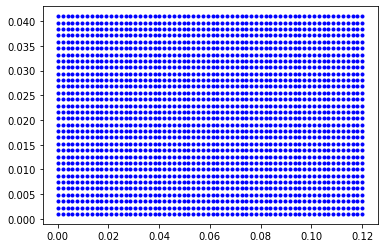

In [ ]:
plt.plot([pt[0] for pt in lst], [pt[1] for pt in lst], 'b.')

# setting up the grid for the magnetic susceptibility

In [ ]:
# battery dimensions
battery_dims=np.array([5,30,40])*1e-3;
# battery is 5 mm thick, 30mm thick, 40mm high
# but all dimensions are in meters so we need the e-3

cell_dims=np.array([5,50,60])*1e-3;  # cell dimensions
# cell is slightly larger than the battery
# the final result map needs to be not confined just to the battery to allow for possible positioning problems 
# also useful check, if you get any signal outside of the battery you know its wrong
# the cell is also the ground for our susceptibility map

print(cell_dims)
print(battery_dims)

[0.005 0.05  0.06 ]
[0.005 0.03  0.04 ]


In [ ]:
#probe_dist=2.3e-2;   # 2 cm top and bottom
#probe_dist=1.59e-2;   # 1.59 cm top and bottom
#probe_dist=1e-2;   # 2 cm top and bottom

probe_dist = 1.59e-4
# smaller probe_dist yields better behaved data
# but too small of a probe_dist yields unstable training

suscept_dims=[1,16,32];
#since we are only concerned with the y-z plane, we will just use 1 pt for x
#this set up how many grid points we want for the magnetic susceptibility map for 1 plane

dV_suscept=np.prod(cell_dims/suscept_dims);   
# this is volume per point in the susceptibility map, seems the correct way

# some recentering of coordinates based on experimental data
# center means the center of the battery
# we need to readjust it because humans cannot place the battery perfectly dead on its center everytime
# for first data
centery=0.021;
centerz=0.06;

# for second data
centery=0.015;
centerz=0.077;

# for damaged cell data
centery=0.020;
centerz=0.065;

# for new send data
centery=0.021;
centerz=0.062;


### convert both the magnetic susceptibility grid positions and the magnetic field positions into lists `[x1,y1,z1; x2,y2,z2; etc ]`


`suscept_pos_list` is the list for every coordinate in the magnetic-susceptibility map

`field_pos_list` is the list for every coordinate in the magnetic-field map

In [ ]:
print(suscept_dims)
print(cell_dims)

[1, 16, 32]
[0.005 0.05  0.06 ]


In [ ]:
print(np.linspace(1,10,10))
print(np.linspace(1,10,10)[1:9])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[2. 3. 4. 5. 6. 7. 8. 9.]


In [ ]:
# this way bottom of cell starts at x=0 (+padding of 1), so the probe_dist is measured from the bottom of cell
suscep_pos=[[],[],[]] 
  # a list of 3 lists
for i in range(3):
    suscep_pos[i]=np.linspace(0, cell_dims[i], suscept_dims[i]+2)
    suscep_pos[i]=suscep_pos[i][1:(suscept_dims[i]+1)]

# recenter all y and z coordinates, but skip x, so only list 1 and 2, not 0
suscep_pos[1]=suscep_pos[1]+centery-cell_dims[1]/2
suscep_pos[2]=suscep_pos[2]+centerz-cell_dims[2]/2

suscep_x_cor,suscep_y_cor,suscep_z_cor=np.meshgrid(suscep_pos[0],suscep_pos[1],suscep_pos[2],indexing='ij')

total_suscep_pts=np.prod(suscept_dims)
assert(np.prod(suscept_dims) == np.prod(suscep_x_cor.shape) 
        == np.prod(suscep_y_cor.shape) == np.prod(suscep_z_cor.shape))

suscept_pos_list=np.concatenate((suscep_x_cor.reshape((total_suscep_pts,1)),
                                 suscep_y_cor.reshape((total_suscep_pts,1)),
                                 suscep_z_cor.reshape((total_suscep_pts,1))
                                 ),
                                axis=1)

In [ ]:
suscep_x_cor.shape

(1, 16, 32)

In [ ]:
# a list of lists, where every list is a [x,y,z] coordinate of the mag-suscept map
suscept_pos_list

array([[ 0.0025    , -0.00105882,  0.03381818],
       [ 0.0025    , -0.00105882,  0.03563636],
       [ 0.0025    , -0.00105882,  0.03745455],
       ...,
       [ 0.0025    ,  0.04305882,  0.08654545],
       [ 0.0025    ,  0.04305882,  0.08836364],
       [ 0.0025    ,  0.04305882,  0.09018182]])

In [ ]:
field_row_v, field_col_v = np.meshgrid(field_row_coor, field_col_coor, indexing='ij')  
# ij indexing produces same shape as newy, newz

In [ ]:
# create field-pos / amp vectors
# remember that for two field components, I would have to stack them
# so maybe best for now to keep them separate (position vs. field measures)
total_field_pts=np.prod(field_row_v.shape)
# y, z, newy, newz

In [ ]:
field_pos_list=np.concatenate((field_col_v.reshape((total_field_pts,1)),
                               field_row_v.reshape((total_field_pts,1))
                               ),
                              axis=1)
field_pos_list=np.insert(field_pos_list,0,probe_dist,axis=1)

In [ ]:
# a list of lists, where every list is a [probe_dist,y,z] coordinate of the mag-field map
field_pos_list

array([[1.590000e-04, 1.000000e-03, 7.400000e-05],
       [1.590000e-04, 2.290320e-03, 7.400000e-05],
       [1.590000e-04, 3.580650e-03, 7.400000e-05],
       ...,
       [1.590000e-04, 3.841935e-02, 1.201020e-01],
       [1.590000e-04, 3.970968e-02, 1.201020e-01],
       [1.590000e-04, 4.100000e-02, 1.201020e-01]])

# Generating Training Set
generating fake magnetic susceptibility distributions and calculating the expected magnetic fields from this based on known `A` coefficient matrix

In [ ]:
num_sim2=600 #can adjust, higher means slower training time but more accurate model

In [ ]:
# function to forwardly calculate mag-field from synthetic mag-suscept

def calcfield(suscept):
  '''
  input:
    suscept: a 3-D tensor of magnetic susceptibility of one battery, must have the shape (16, 32, #_of_chanels)
  return:
    fieldz: 2-D matrix of the z-component of magnetic field vector space
  '''
  source_vec=np.squeeze(suscept[:,:,:])
  fieldz = np.fft.fft2(source_vec)
  fieldz = np.fft.fftshift(fieldz)
  # fieldz = np.real(fieldz)
  # leave the modification for later
  return fieldz

In [ ]:
print(suscept_dims)

[1, 16, 32]


In [ ]:
output_suscept=np.zeros((num_sim2, suscept_dims[2], suscept_dims[1],1)) 
# pre-allocate tensor for holding label values
# 1 chanel for susceptibility


input_field=np.empty((num_sim2, suscept_dims[2], suscept_dims[1],1), dtype=complex) 
# pre-allocate tensor for holding training data
# for FT, must be the same shape as the suscept labels
# set the dtype to be accepting complex values

In [ ]:
# generate random magntic susceptibility distributions, based on a set of random gaussian peaks 

maxlevelrange=200e-6
  # could just set this to 200
  # and then know that the number has the ppm unit
numberpeaks=10;
idx1=range(int(suscept_dims[2]))
idx2=range(int(suscept_dims[1]))
midx1,midx2=np.meshgrid(idx1,idx2,indexing='ij')
for ii in range(num_sim2):
    # for now just produce z susceptibility (easier for checking result?)
    
    # here provide alternative training set  exp(-x^2/(2sigma^2))
  if True:
    for iii in range(numberpeaks):
      pos1=np.random.rand(1)*suscept_dims[2]
      pos2=np.random.rand(1)*suscept_dims[1]
      w1=np.random.rand(1)*suscept_dims[2]/5+1
      w2=np.random.rand(1)*suscept_dims[1]/5+1
      amp=np.random.rand(1)*maxlevelrange
      output_suscept[ii, :, :,0]=output_suscept[ii, :, :,0]+amp*np.exp(-((midx1-pos1)/w1)**2-((midx2-pos2)/w2)**2)
      # notice that we only generated the z-components of the mag-suscept
  else:
    # for network best to create the susceptibility in the transposed version
    #output_suscept[ii, :, :,2] = maxlevelrange*np.random.rand(suscept_dims[1], suscept_dims[2])
    output_suscept[ii, :, :,0] = maxlevelrange*np.random.rand(suscept_dims[2], suscept_dims[1])  # only z susceptibility for now 
        
  input_field[ii, :, :,0] = (calcfield(output_suscept[ii,:,:,:]))
  # so the input data will be the mag-field, chanel 0 will be y-component, chanel 1 will be z-component
  # but here since fft is 1-to-1, only have 1 channel which is channel 0
  # the output, or what we are trying to predict, are the mag-susceptibilities

  # a useful unit is 10e-12, since we already did 10e6 for the suscept, we can just multiply field by another 10e6 to get that unit
    

In [ ]:
np.all(input_field[30,:,:,0] == calcfield(output_suscept[30,:,:,:]))

True

In [ ]:
input_field[0][0]

array([[-3.72183148e-07+0.00000000e+00j],
       [-3.41201099e-07-1.39025190e-08j],
       [ 5.25179820e-07+4.52388957e-07j],
       [ 2.90896388e-06+6.01620654e-07j],
       [ 2.94659154e-06-9.14251960e-06j],
       [-2.76791037e-05-1.83748520e-05j],
       [-2.68296366e-06+6.14657326e-05j],
       [-4.62959892e-05-1.18653814e-05j],
       [ 1.54298047e-04+0.00000000e+00j],
       [-4.62959892e-05+1.18653814e-05j],
       [-2.68296366e-06-6.14657326e-05j],
       [-2.76791037e-05+1.83748520e-05j],
       [ 2.94659154e-06+9.14251960e-06j],
       [ 2.90896388e-06-6.01620654e-07j],
       [ 5.25179820e-07-4.52388957e-07j],
       [-3.41201099e-07+1.39025190e-08j]])

In [ ]:
def imshow_center(data):
  '''
  Display 1 chanel of the data as an image; i.e. on a 2D regular raster.
  input:
    data: a single battery's 
      magnetic field image that is a 2-D array with shape [64,32] with scalar data,
      or magnetic susceptibility image that is a 2-D array with shape [32,16]
  output:
    figure/image displaying all the range of values
  '''
  maxval=np.max(np.abs(data))
  plt.imshow(data, cmap="seismic",vmin=-maxval,vmax=maxval)
  plt.colorbar()

In [ ]:
print((input_field[33,:,:,0]).shape)
# print((train_images_t2b[33,:,:,1]).shape)
print((input_field).shape)

(32, 16)
(600, 32, 16, 1)


So I have 600 battery samples in my training set, each battery sample has 2 dimensions where each dimension is a magnetic field map of size (64$\small{\times}$32). The magnetic field is the input to my model.

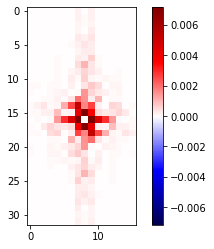

In [ ]:
imshow_center(np.abs(np.imag(input_field[33,:,:,0])))
plt.savefig('training_input_imag.png')

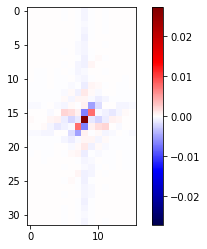

In [ ]:
imshow_center(np.real(input_field[33,:,:,0]))
plt.savefig('training_input_real.png')

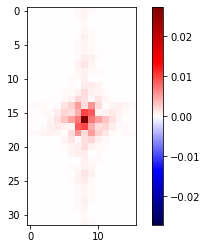

In [ ]:
imshow_center(np.abs(input_field[33,:,:,0]))
plt.savefig('training_sample_abs.png')

In [ ]:
print((output_suscept[33,:,:,0]).shape)
print((output_suscept).shape)

(32, 16)
(600, 32, 16, 1)


So I have 600 battery samples in my training set, each battery sample has 1 dimensions where each dimension is a magnetic susceptibility map of size (32$\times$16). The magnetic susceptibility is my model output, what I am trying to predict/label. 

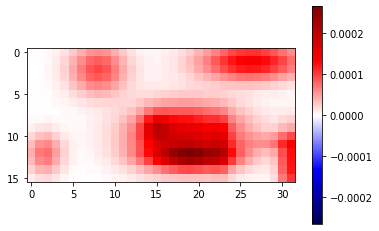

In [ ]:
# for historical reasons, the magnetic susceptibility map shows up transpose, 
# I guess it would be good to change that at some point, but for now keeping it 
imshow_center(np.transpose(output_suscept[33,:,:,0]))
plt.savefig('training_label.png')

note that here we only have positive values ($>0$) in our magnetic susceptibility map. 

Magnetic susceptibility of a material is defined as the ratio of the intensity of magnetisation ($I$) induced in the material to the magnetisation force ($H$) applied on it. 

Substances such as copper, lead, etc. have negative susceptibility. These substances are called diamagnetic substances. Substances with negative susceptibility signify that they are repelled by magnets.

Substances such as aluminium, calcium, etc. have positive susceptibility. These substances are called paramagnetic substances. 

Read more on Brainly.in - https://brainly.in/question/282451#readmore

## train, validation, test split

In [ ]:
choice = input("abs, real, imag, comp: ")
if choice == "abs":
  input_field = np.abs(input_field)
  print("taking absolute value of the complex FFT mag-field")
elif choice == "real":
  input_field = np.real(input_field)
  print("taking the real part of the complex FFT mag-field")
elif choice == "imag":
  input_field = np.imag(input_field)
  print("taking the imaginary part of the complex FFT mag-field")
else:
  print("taking the entire complex number of the complex FFT mag-field")

abs, real, imag, comp: imag
taking the imaginary part of the complex FFT mag-field


In [ ]:
# train, validation, and test split

# a list of random indices thats 40% of the samples
val_test_idx = random.sample(range(num_sim2), int(0.4*num_sim2))
# get the remainder of the indices as train
train_idx = np.setdiff1d(range(num_sim2),val_test_idx)

val_data = input_field[val_test_idx[:int(0.4*num_sim2/2)], :, :, :]
val_labels = output_suscept[val_test_idx[:int(0.4*num_sim2/2)], :, :, :]

test_data = input_field[val_test_idx[int(0.4*num_sim2/2):], :, :, :]
test_labels = output_suscept[val_test_idx[int(0.4*num_sim2/2):], :, :, :]

train_data = input_field[train_idx, :, :, :]
train_labels = output_suscept[train_idx, :, :, :]

print(val_data.shape)
print(val_labels.shape)
print(30*'-')
print(test_data.shape)
print(test_labels.shape)
print(30*'-')
print(train_data.shape)
print(train_labels.shape)

(120, 32, 16, 1)
(120, 32, 16, 1)
------------------------------
(120, 32, 16, 1)
(120, 32, 16, 1)
------------------------------
(360, 32, 16, 1)
(360, 32, 16, 1)


In [ ]:
# just making sure we paired the input and output correctly
# of course, use abs / real / imag per how you transformed the training data
np.all(test_data[30,:,:,0] == (calcfield(test_labels[30,:,:,:])))

False

In [ ]:
output_suscept[3, :, :,0][0]

array([3.76855930e-09, 9.05122475e-09, 1.77911699e-08, 2.86198153e-08,
       3.76785612e-08, 4.05963470e-08, 3.57968463e-08, 2.58325803e-08,
       1.52566472e-08, 7.37807842e-09, 2.99913516e-09, 1.91327854e-09,
       6.74868800e-09, 2.48426394e-08, 5.37878350e-08, 6.63581914e-08])

In [ ]:
input_field[3, :, :,0][0]

array([ 0.00000000e+00, -6.87880310e-06,  2.14972625e-05,  4.16246452e-05,
       -1.41264215e-05, -5.12059405e-05,  1.04379305e-04,  2.93932712e-04,
        0.00000000e+00, -2.93932712e-04, -1.04379305e-04,  5.12059405e-05,
        1.41264215e-05, -4.16246452e-05, -2.14972625e-05,  6.87880310e-06])

In [ ]:
# TF requires this kind of transformation into tensor
train_images_t2b=tf.constant(train_data)
train_labels_t2b=tf.constant(train_labels)

val_images_t2b=tf.constant(val_data)
val_labels_t2b=tf.constant(val_labels)

test_images_t2b=tf.constant(test_data)
test_labels_t2b=tf.constant(test_labels)

train_images_t2b.shape
# the input images are the magnetic field map for all batteries

TensorShape([360, 32, 16, 1])

In [ ]:
test_labels_t2b.shape
# the output images are the magnetic susceptibility map for all batteries

TensorShape([120, 32, 16, 1])

# Model setup
model based on papers (Bollman, etc) with some modifications, links given

## define model functions

In [ ]:
#adapted from https://colab.research.google.com/drive/1ltjXmi6fSAe4YBgJrmHH_wjTl9VxFRgl

def get_figure():
    """
    Returns:
      an emtpy figure object and an empty axis object to plot on. 
    
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

In [ ]:
def conv_block_h2(input_tensor, num_filters, dropout_level = 0.15):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Dropout(dropout_level)(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block_h2(input_tensor, num_filters, dropout_level = 0.15):
    encoder = layers.BatchNormalization()(input_tensor) # added a first normalization layer
    encoder = conv_block_h2(encoder, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block_h2(input_tensor, concat_tensor, num_filters, dropout_level = 0.15):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Dropout(dropout_level)(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

## define loss functions

In [ ]:
# define the loss function for TF, for now just the squared difference beetween predicted and true magnetic fields
def custom_loss_mse(y_true,y_pred):
    # print("y_pred shape:",y_pred[0,:,:,0].shape)
    # penalty=batt_mask128(y_pred[0,:,:,0])
    # loss=K.mean(K.square(y_pred-y_true),axis=-1)+np.sum(0*np.abs(penalty)) #can adjust the penalty weight
    loss=K.mean(K.square(y_pred-y_true),axis=None)  #+K.sum(0*K.abs(penalty)) #can adjust the penalty weight
    return loss

def custom_loss_rmse(y_true,y_pred):
    loss=K.sqrt(K.mean(K.square(y_pred-y_true),axis=None))  #+K.sum(0*K.abs(penalty)) #can adjust the penalty weight
    return loss

def custom_loss_abs(y_true,y_pred):
    loss=K.mean(K.abs(y_pred-y_true),axis=None)  #+K.sum(0*K.abs(penalty)) #can adjust the penalty weight
    return loss

In [ ]:
inputs_h2 = layers.Input(shape=(32,16,1))
# the dimension for EACH image in the training set

encoder0_pool_h2, encoder0_h2 = encoder_block_h2(inputs_h2, 8, dropout_level = 0.15)
encoder1_pool_h2, encoder1_h2 = encoder_block_h2(encoder0_pool_h2, 16, dropout_level = 0.15)
encoder2_pool_h2, encoder2_h2 = encoder_block_h2(encoder1_pool_h2, 32, dropout_level = 0.15)
encoder3_pool_h2, encoder3_h2 = encoder_block_h2(encoder2_pool_h2, 64, dropout_level = 0.15)
center_h2 = conv_block_h2(encoder3_pool_h2, 128, dropout_level = 0.15)
decoder3_h2 = decoder_block_h2(center_h2, encoder3_h2, 64, dropout_level = 0.15)
decoder2_h2 = decoder_block_h2(decoder3_h2, encoder2_h2, 32, dropout_level = 0.15)
decoder1_h2 = decoder_block_h2(decoder2_h2, encoder1_h2, 16, dropout_level = 0.15)
decoder0_h2 = decoder_block_h2(decoder1_h2, encoder0_h2, 8, dropout_level = 0.15)
  # add one more layer to get the same output shape as input shape

outputs_h2 = layers.Conv2D(1, (1, 1), padding="same")(decoder0_h2)   
  # simply set number of output channels here as the first argument, seems legit

In [ ]:
model_ht2b = models.Model(inputs=[inputs_h2], outputs=[outputs_h2])

adam=keras.optimizers.Adam(beta_2=0.999, learning_rate=0.001)

model_ht2b.compile(optimizer=adam,
                   loss=custom_loss_rmse) # let's use rmse for optimization becuase it is a bigger target than mse
                   # we will also use the RMSE for final evaluation

model_ht2b.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 16, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 16, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 16, 8)    80          batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 16, 8)    32          conv2d[0][0]                     
_______________________________________________________________________________________

**notice how the input and output shapes MUST match with EACH battery in our `training_image` and `training_label` shapes**

# Training the model

In [ ]:
# checkpoint for saving the best model only, so it overwrites itself
# could also save a model every time the monitor gets better as another option
filepath="model.best.h5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', # this must be the same exact string as a metric from your model training verbose output
                             verbose=1, 
                             save_best_only=True, # only save the best model and keep overwriting
                             mode='min', # we want minimum loss
                             save_weights_only=False # we want to save the entire model
                             )
callbacks_list = [checkpoint]

In [ ]:
# I read that using adam with learning rate 0.001 is good

num_epochs=60   
  #can adjust ultimately should be quite large

history_ht2b = model_ht2b.fit(train_images_t2b, 
                              train_labels_t2b,
                              validation_data = (val_images_t2b, val_labels_t2b),  
                              epochs=num_epochs, 
                              batch_size=32, 
                              shuffle=True,
                              callbacks = callbacks_list,
                              verbose=1)

Epoch 1/60
12/12 [==============================] - ETA: 0s - loss: 0.5263
Epoch 00001: val_loss improved from inf to 0.01435, saving model to model.best.h5
12/12 [==============================] - 2s 200ms/step - loss: 0.5263 - val_loss: 0.0144
Epoch 2/60
 9/12 [=====================>........] - ETA: 0s - loss: 0.3144
Epoch 00002: val_loss did not improve from 0.01435
12/12 [==============================] - 0s 16ms/step - loss: 0.2978 - val_loss: 0.0468
Epoch 3/60
12/12 [==============================] - ETA: 0s - loss: 0.1424
Epoch 00003: val_loss did not improve from 0.01435
12/12 [==============================] - 0s 17ms/step - loss: 0.1424 - val_loss: 0.1049
Epoch 4/60
 9/12 [=====================>........] - ETA: 0s - loss: 0.0671
Epoch 00004: val_loss did not improve from 0.01435
12/12 [==============================] - 0s 16ms/step - loss: 0.0643 - val_loss: 0.1325
Epoch 5/60
 9/12 [=====================>........] - ETA: 0s - loss: 0.0438
Epoch 00005: val_loss did not improve

60
60


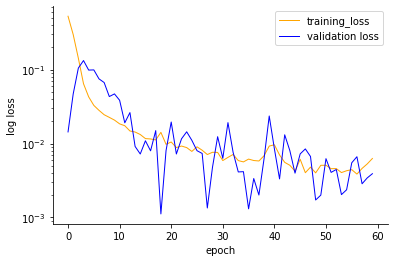

In [ ]:
# plot loss fn vs. epochs

#adapted from https://colab.research.google.com/drive/1ltjXmi6fSAe4YBgJrmHH_wjTl9VxFRgl

train_loss_history_ht2b = history_ht2b.history['loss']
val_loss_history_ht2b = history_ht2b.history['val_loss']
print(len(train_loss_history_ht2b))
print(len(val_loss_history_ht2b))

fig, ax = get_figure()
# fig.set_size_inches(10,6)

startpoints=0
ax.set_yscale('log') # set y-axis to log_10 scale for better viewing
ax.plot((np.arange(num_epochs*1))[startpoints:], train_loss_history_ht2b[startpoints:], linewidth=1, color="orange", label="training_loss")
ax.plot((np.arange(num_epochs*1))[startpoints:], val_loss_history_ht2b[startpoints:], linewidth=1, color="blue", label="validation loss")
ax.set_xlabel('epoch')
ax.set_ylabel('log loss')
ax.legend(frameon=True);

# ___ epochs until convergence

In [ ]:
# val_loss_history_ht2b

In [ ]:
fig.savefig('history.png')

In [ ]:
# save in one step
# model_ht2b.save('model.h5')

In [ ]:
# save history (if needed separately)
with open('train_history.db', 'wb') as file_pi:
  pk.dump(train_loss_history_ht2b, file_pi)

# save history (if needed separately)
with open('val_history.db', 'wb') as file_pi:
  pk.dump(val_loss_history_ht2b, file_pi)

## Loading Saved Model

In [ ]:
# just for testing that I can read in model and proceed from here
del model_ht2b
del history_ht2b
del train_loss_history_ht2b

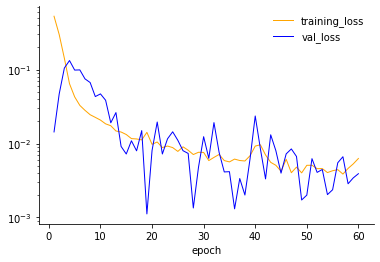

In [ ]:
loss_history_ht2b = pk.load(open('train_history.db', "rb"))
val_loss_history_ht2b = pk.load(open('val_history.db', "rb"))
fig, ax = get_figure()
num_epochs=len(loss_history_ht2b)
startpoints=0
ax.set_yscale('log')
ax.plot((np.arange(num_epochs*1)+1)[startpoints:], loss_history_ht2b[startpoints:], linewidth=1, color="orange", label="training_loss")
ax.plot((np.arange(num_epochs*1)+1)[startpoints:], val_loss_history_ht2b[startpoints:], linewidth=1, color="blue", label="val_loss")
ax.set_xlabel('epoch')
ax.legend(frameon=False);

In [ ]:
# load in one step
# fixed with adding custom_loss function, in future, better to save model and weights separately?
adam=keras.optimizers.Adam(beta_2=0.999, learning_rate=0.001)
model_ht2b=tf.keras.models.load_model('model.best.h5',custom_objects={'custom_loss_rmse': custom_loss_rmse})

In [ ]:
# do I need to recompile after loading?
model_ht2b.compile(optimizer=adam,
                   loss=custom_loss_rmse)

## predict on 1 sample from the trianing set

(1, 32, 16, 1)
(1, 32, 16, 1)


Text(0.5, 1.0, 'error between predicted and true susceptibility')

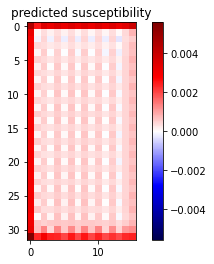

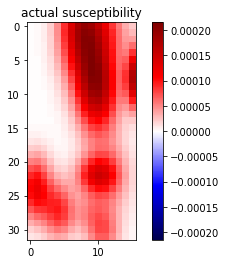

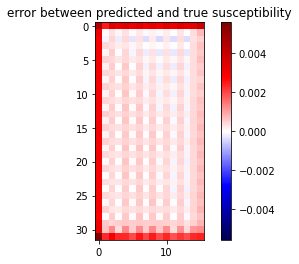

In [ ]:
# Predicting the one training data
# adapted from https://colab.research.google.com/drive/1ltjXmi6fSAe4YBgJrmHH_wjTl9VxFRgl

test_patch_nbr = 20
susax=0
  # this is the only chanel of the susceptibility volume
  # we only look at this bc only this chanel has meaningful values
  # bc we only generated the z-component of the susceptibility

X_test = train_images_t2b[np.newaxis,20,:,:,:] # a single battery input image from the training set 
# why do I need to add new axis for prediction set?                    
# because this just extracts the 20th battery in the trianing set, this is a single instance
# so it needs a new axis because it has 1 less axis than when you trianed on all instances at once

print(X_test.shape)
y_pred_ht2 = model_ht2b.predict(X_test)
print(y_pred_ht2.shape)

plt.figure()
imshow_center(y_pred_ht2[0,:,:,susax])
plt.title("predicted susceptibility")

plt.figure()
imshow_center(train_labels_t2b[test_patch_nbr,:,:,susax])
plt.title("actual susceptibility")

plt.figure()
imshow_center(y_pred_ht2[0,:,:,susax]-train_labels_t2b[test_patch_nbr,:,:,susax])
# plot the predicted susceptibility - actual susceptibility in the same dimension which is 2
plt.title("error between predicted and true susceptibility")



In [ ]:
y_pred_ht2.shape

(1, 32, 16, 1)

taking the imaginary part of the complex FFT mag-field


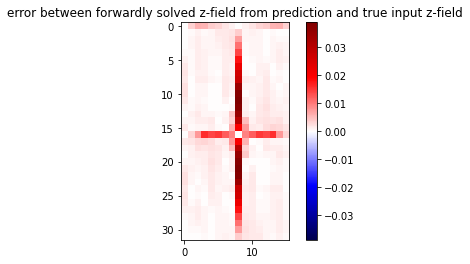

In [ ]:
zf=calcfield(y_pred_ht2[0,:,:,:])
# yf and zf end up too large
# calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
# from the predicted susceptibility output
# so we are kind of like recreating the input to see if it is the same as the actual input
# to see if the model learned the dipole forward kernel well

if choice == "abs":
  zf = np.abs(zf)
  print("taking absolute value of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[0,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "real":
  zf = np.real(zf)
  print("taking the real part of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[0,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "imag":
  zf = np.imag(zf)
  print("taking the imaginary part of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[0,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
else:
  print("taking the entire complex number of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[0,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")

# plt.figure()
# imshow_center(np.squeeze(X_test[0,:,:,0])-yf)
# plt.title("error between forwardly solved y-field from prediction and true input y-field")


## predict on the entire test set

<Figure size 432x288 with 0 Axes>

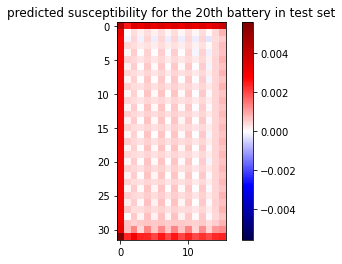

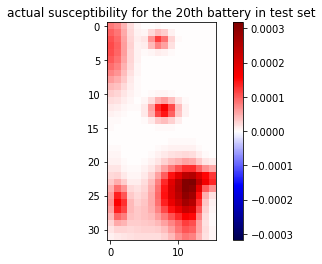

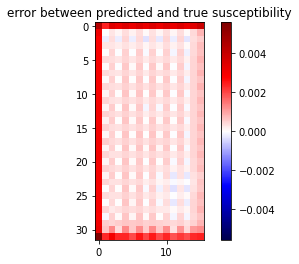

In [ ]:
# predicting on the entire test set
susax=0
X_test = test_images_t2b
y_pred_ht2 = model_ht2b.predict(test_images_t2b)
plt.figure()

plt.figure()
imshow_center(y_pred_ht2[20,:,:,susax])
plt.title("predicted susceptibility for the 20th battery in test set")
plt.savefig("test_20_pred.png")

plt.figure()
imshow_center(test_labels_t2b[20,:,:,susax])
plt.title("actual susceptibility for the 20th battery in test set")
plt.savefig("test_20_true.png")

plt.figure()
imshow_center(y_pred_ht2[20,:,:,susax]-test_labels_t2b[20,:,:,susax])
# plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the 20th battery in test set
# we want this difference to be as small as possible, not too extreme in either way
plt.title("error between predicted and true susceptibility")
plt.savefig('test_20_error.png')



taking the imaginary part of the complex FFT mag-field


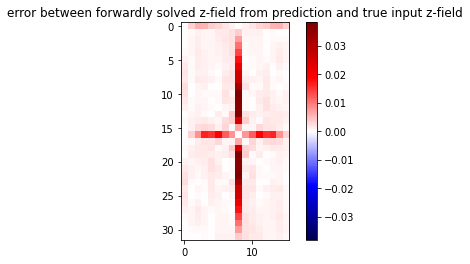

In [ ]:
zf=calcfield(y_pred_ht2[20,:,:,:])
# calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
# from the predicted susceptibility output
# so we are kind of like recreating the input to see if it is the same as the actual input
# to see if the model learned the dipole forward kernel well

if choice == "abs":
  zf = np.abs(zf)
  print("taking absolute value of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[20,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "real":
  zf = np.real(zf)
  print("taking the real part of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[20,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "imag":
  zf = np.imag(zf)
  print("taking the imaginary part of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[20,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
else:
  print("taking the entire complex number of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[20,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")

# plt.figure()
# imshow_center(np.squeeze(X_test[20,:,:,0])-yf)
# plt.title("error between forwardly solved y-field from prediction and true input y-field")
# plt.savefig('test_20_yfield_diff.png')


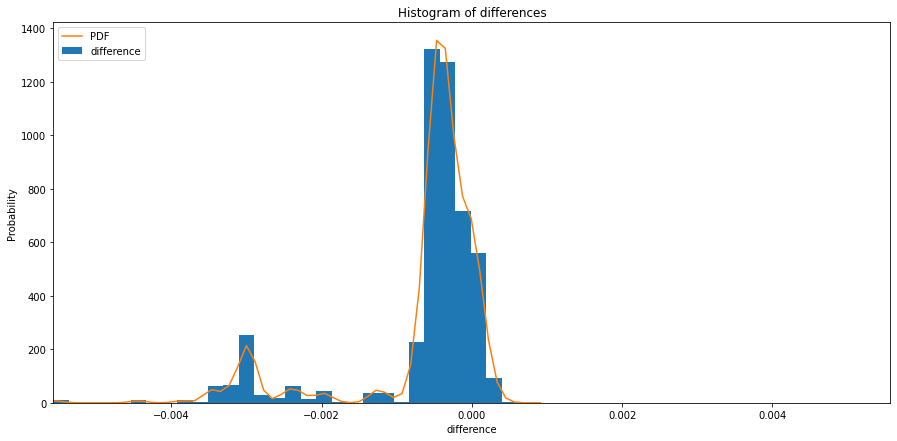

In [ ]:
test_diff = test_labels_t2b - y_pred_ht2
test_diff = tf.keras.backend.flatten(test_diff)

plt.figure(figsize=(15,7))
plt.hist(test_diff, bins=30, density=True, label='difference');
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 60)
kde = stats.gaussian_kde(test_diff)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel('Probability')
plt.xlabel('difference')
range = np.max([np.abs(np.min(test_diff)), np.abs(np.max(test_diff))])
plt.xlim(-range, range)
plt.title("Histogram of differences");
plt.savefig("test_diff_hist.png")

### calculate final loss

In [ ]:
final_loss = custom_loss_rmse(test_labels_t2b, y_pred_ht2)
print('final RMSE loss on test set:', final_loss.numpy())
NRMSE = final_loss/K.mean(test_labels_t2b)
print('final normalized RMSE loss (div mean) on the test set:', NRMSE.numpy())
RMSE_range = final_loss /(tf.reduce_max(test_labels_t2b) - tf.reduce_min(test_labels_t2b))
print('final normalized RMSE loss (div range) on the test set:', RMSE_range.numpy())
test_arr = tf.keras.backend.flatten(test_labels_t2b).numpy()
IQR = stats.iqr(test_arr)
RMSE_IQR = final_loss/IQR
print('final normalized RMSE loss (div IQR) on the test set:', RMSE_IQR.numpy())
Boll_NRMSE = tf.norm(y_pred_ht2-test_labels_t2b) / tf.norm(test_labels_t2b)
print('final Bollman normalized RMSE loss on the test set:', Boll_NRMSE.numpy())

final RMSE loss on test set: 0.0011175351023996966
final normalized RMSE loss (div mean) on the test set: 20.422419709802305
final normalized RMSE loss (div range) on the test set: 2.254500501165893
final normalized RMSE loss (div IQR) on the test set: 14.436164787952764
final Bollman normalized RMSE loss on the test set: 13.68561451279893


In [ ]:
y_pred_ht2[20,:,:,0][0]

array([0.00445898, 0.00248521, 0.00350256, 0.00319536, 0.00351764,
       0.00319827, 0.00349577, 0.00318593, 0.00349711, 0.00317775,
       0.00349277, 0.0031852 , 0.00350521, 0.003159  , 0.00341991,
       0.00387959], dtype=float32)

In [ ]:
test_labels_t2b[20,:,:,0][0]

<tf.Tensor: shape=(16,), dtype=float64, numpy=
array([8.36463283e-05, 7.23345707e-05, 4.53592640e-05, 2.06266923e-05,
       6.83214171e-06, 1.98566035e-06, 1.94279687e-06, 3.11160867e-06,
       2.28769268e-06, 6.80444467e-07, 8.12234787e-08, 3.88807884e-09,
       7.46300880e-11, 5.74447252e-13, 1.77427538e-15, 2.21344848e-18])>

In [ ]:
# check memory address
id(y_pred_ht2[20,:,:,0])

140305188928208

In [ ]:
# check memory address
id(y_pred_ht2[30,:,:,0])

140305188735936

### plot `Boll_NRMSE` for each battery to see if prediction is bad consistently or good for some and bad for some 

In [ ]:
y_pred_ht2.shape

(120, 32, 16, 1)

In [ ]:
test_labels_t2b.shape

TensorShape([120, 32, 16, 1])

In [ ]:
y_pred_ht2[0,:,:,:].shape

(32, 16, 1)

In [ ]:
test_labels_t2b[0,:,:,:].shape

TensorShape([32, 16, 1])

In [ ]:
Boll_NRMSE_test_lst = []

for i in np.arange(int(test_labels_t2b.shape[0])):
  # print(i)
  Boll_NRMSE = (tf.norm(y_pred_ht2[i,:,:,:]-test_labels_t2b[i,:,:,:]) 
                / tf.norm(test_labels_t2b[i,:,:,:]))
  Boll_NRMSE_test_lst.append(Boll_NRMSE)

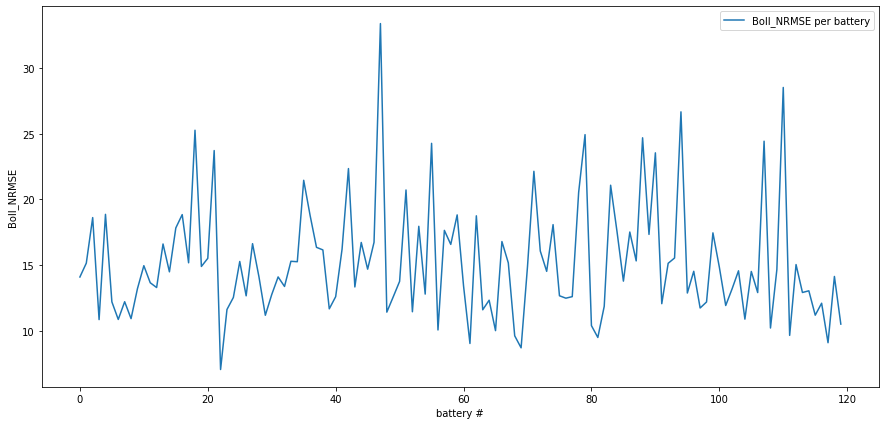

In [ ]:
fig1 = plt.figure(figsize=(15,7))
plt.plot(Boll_NRMSE_test_lst, label="Boll_NRMSE per battery")
plt.legend()
plt.xlabel("battery #")
plt.ylabel("Boll_NRMSE")
plt.savefig("Boll_NRMSE_per_battery.png")

The best predicted battery is battery 22 from the test set with a Boll_NRMSE of  7.039020501425249
taking the imaginary part of the complex FFT mag-field


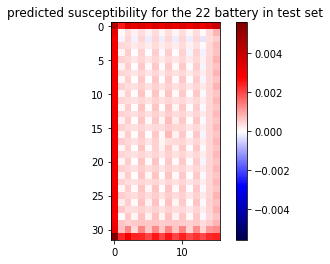

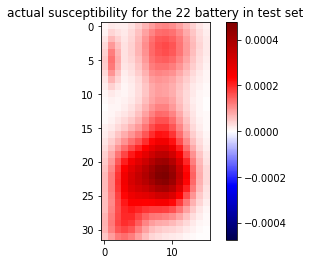

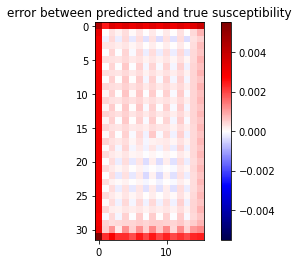

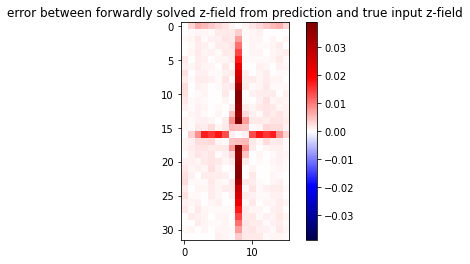

In [ ]:
best_batt = np.argmin(Boll_NRMSE_test_lst)
best_batt_NRMSE = min(Boll_NRMSE_test_lst).numpy()
print("The best predicted battery is battery", best_batt, "from the test set with a Boll_NRMSE of ", best_batt_NRMSE)

plt.figure()
imshow_center(y_pred_ht2[best_batt,:,:,susax])
plt.title("predicted susceptibility for the "+str(best_batt)+" battery in test set")
plt.savefig("test_best_pred.png")

plt.figure()
imshow_center(test_labels_t2b[best_batt,:,:,susax])
plt.title("actual susceptibility for the "+str(best_batt)+" battery in test set")
plt.savefig("test_best_true.png")

plt.figure()
imshow_center(y_pred_ht2[best_batt,:,:,susax]-test_labels_t2b[best_batt,:,:,susax])
# plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the best battery in test set
# we want this difference to be as small as possible, not too extreme in either way
plt.title("error between predicted and true susceptibility")
plt.savefig('test_best_error.png')

zf=calcfield(y_pred_ht2[best_batt,:,:,:])
# calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
# from the predicted susceptibility output
# so we are kind of like recreating the input to see if it is the same as the actual input
# to see if the model learned the dipole forward kernel well

if choice == "abs":
  zf = np.abs(zf)
  print("taking absolute value of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[best_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "real":
  zf = np.real(zf)
  print("taking the real part of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[best_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "imag":
  zf = np.imag(zf)
  print("taking the imaginary part of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[best_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
else:
  print("taking the entire complex number of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[best_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")

# plt.figure()
# imshow_center(np.squeeze(X_test[best_batt,:,:,0])-yf)
# plt.title("error between forwardly solved y-field from prediction and true input y-field")
# plt.savefig('test_best_yfield_diff.png')


The worst predicted battery is battery  47 from the test set with a Boll_NRMSE of  33.411559405939215
taking the imaginary part of the complex FFT mag-field


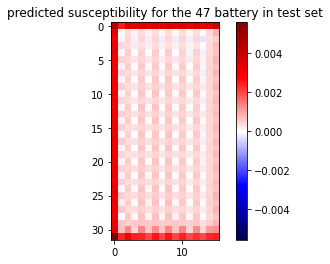

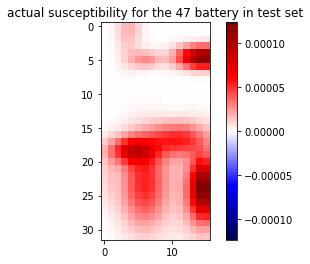

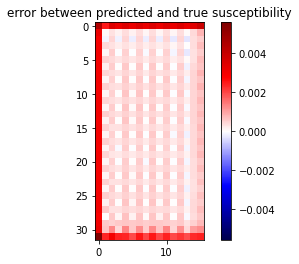

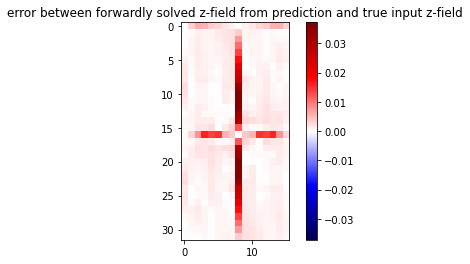

In [ ]:
worst_batt = np.argmax(Boll_NRMSE_test_lst)
worst_batt_NRMSE = max(Boll_NRMSE_test_lst).numpy()
print("The worst predicted battery is battery ", worst_batt, "from the test set with a Boll_NRMSE of ", worst_batt_NRMSE)

plt.figure()
imshow_center(y_pred_ht2[worst_batt,:,:,susax])
plt.title("predicted susceptibility for the "+str(worst_batt)+" battery in test set")
plt.savefig("test_worst_pred.png")

plt.figure()
imshow_center(test_labels_t2b[worst_batt,:,:,susax])
plt.title("actual susceptibility for the "+str(worst_batt)+" battery in test set")
plt.savefig("test_worst_true.png")

plt.figure()
imshow_center(y_pred_ht2[worst_batt,:,:,susax]-test_labels_t2b[worst_batt,:,:,susax])
# plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the best battery in test set
# we want this difference to be as small as possible, not too extreme in either way
plt.title("error between predicted and true susceptibility")
plt.savefig('test_worst_error.png')

zf=calcfield(y_pred_ht2[worst_batt,:,:,:])
# calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
# from the predicted susceptibility output
# so we are kind of like recreating the input to see if it is the same as the actual input
# to see if the model learned the dipole forward kernel well

if choice == "abs":
  zf = np.abs(zf)
  print("taking absolute value of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[worst_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "real":
  zf = np.real(zf)
  print("taking the real part of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[worst_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "imag":
  zf = np.imag(zf)
  print("taking the imaginary part of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[worst_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
else:
  print("taking the entire complex number of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[worst_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")

# plt.figure()
# imshow_center(np.squeeze(X_test[worst_batt,:,:,0])-yf)
# plt.title("error between forwardly solved y-field from prediction and true input y-field")
# plt.savefig('test_worst_yfield_diff.png')


#### check one-sample predictions

In [ ]:
# making sure the pairing is still correct
np.all(test_images_t2b[10,:,:,0].numpy() == calcfield(test_labels_t2b[10,:,:,:].numpy()))

False

In [ ]:
y_pred_10 = model_ht2b.predict(test_images_t2b[np.newaxis,10,:,:,:])
y_pred_30 = model_ht2b.predict(test_images_t2b[np.newaxis,30,:,:,:])

print(y_pred_10.shape)
print(y_pred_30.shape)
print(y_pred_ht2.shape)
print(test_labels_t2b.shape)

(1, 32, 16, 1)
(1, 32, 16, 1)
(120, 32, 16, 1)
(120, 32, 16, 1)


In [ ]:
np.all(y_pred_10 == y_pred_30)

False

In [ ]:
np.all(y_pred_10 == model_ht2b.predict(test_images_t2b[np.newaxis,10,:,:,:]))

True

In [ ]:
np.all(model_ht2b.predict(test_images_t2b[np.newaxis,30,:,:,:]) == y_pred_ht2[30,:,:,:])

False

In [ ]:
y_pred_10[0][0]

array([[0.00445905],
       [0.00248521],
       [0.00350257],
       [0.00319536],
       [0.00351761],
       [0.0031983 ],
       [0.0034958 ],
       [0.00318594],
       [0.0034971 ],
       [0.00317775],
       [0.0034928 ],
       [0.00318519],
       [0.00350519],
       [0.00315899],
       [0.00341988],
       [0.00387956]], dtype=float32)

In [ ]:
y_pred_ht2[10][0]

array([[0.00445903],
       [0.00248525],
       [0.00350259],
       [0.00319534],
       [0.00351759],
       [0.0031983 ],
       [0.0034958 ],
       [0.00318597],
       [0.00349713],
       [0.00317772],
       [0.00349276],
       [0.00318519],
       [0.00350518],
       [0.00315901],
       [0.00341988],
       [0.00387959]], dtype=float32)

So the reason you are not getting the exact same result when predicting on just one sample Vs. predicting on the entire test set are just trivial rounding differences. In actuality the results do match. I.e., the $10^{th}$ prediction from the entire predictions set matches the prediction on the $10^{th}$ input in the test set.

# Grid Search over Model

In [ ]:
# our model might not be able to be wrapped in a scikit_learn model
# so we have to do the for-loops by hand
# train and val sets are not part of the input, so they must be defined as global variables prior

def grid_search(dropout_level_lst=[0.05], beta2_lst=[0.999], beta1_lst=[0.9], lr_rate_lst = [0.001],
                epsilon_lst=[1e-08], epo_lst = [10], bat_size_lst = [10]):
  # initialize values
  val_loss = np.inf
  best_params = dict()

  for dp_level in dropout_level_lst:
    inputs_h2 = layers.Input(shape=(32,16,1))
    # same as (rscale, cscale, 2)
    # also same as the dimension for EACH image in the training set
    encoder0_pool_h2, encoder0_h2 = encoder_block_h2(inputs_h2, 8, dropout_level=dp_level)
    encoder1_pool_h2, encoder1_h2 = encoder_block_h2(encoder0_pool_h2, 16, dropout_level=dp_level)
    encoder2_pool_h2, encoder2_h2 = encoder_block_h2(encoder1_pool_h2, 32, dropout_level=dp_level)
    encoder3_pool_h2, encoder3_h2 = encoder_block_h2(encoder2_pool_h2, 64, dropout_level=dp_level)
    center_h2 = conv_block_h2(encoder3_pool_h2, 128, dropout_level=dp_level)
    decoder3_h2 = decoder_block_h2(center_h2, encoder3_h2, 64, dropout_level=dp_level)
    decoder2_h2 = decoder_block_h2(decoder3_h2, encoder2_h2, 32, dropout_level=dp_level)
    decoder1_h2 = decoder_block_h2(decoder2_h2, encoder1_h2, 16, dropout_level=dp_level)
    decoder0_h2 = decoder_block_h2(decoder1_h2, encoder0_h2, 8, dropout_level = dp_level)
    outputs_h2 = layers.Conv2D(1, (1, 1), padding="same")(decoder0_h2)   # simply set number of output channels here, seems legit

    model_ht2b = models.Model(inputs=[inputs_h2], outputs=[outputs_h2])

    for beta2 in beta2_lst:
      for beta1 in beta1_lst:
        for lr_rate in lr_rate_lst:
          for eps in epsilon_lst:
            adam=keras.optimizers.Adam(learning_rate = lr_rate, beta_1 = beta1, beta_2=beta2, epsilon = eps)

            model_ht2b.compile(optimizer=adam,
                               loss=custom_loss_rmse) # let's use rmse for optimization becuase it is a bigger target than mse

            # construct checkpoint for saving the best model for current training
            filepath="current.best.h5"
            checkpoint = ModelCheckpoint(filepath, 
                                        monitor='val_loss', # this must be the same string as a metric from your model training verbose output
                                        verbose=1, 
                                        save_best_only=True, 
                                        mode='min', # we want minimum loss
                                        save_weights_only=False # we want to save the entire model, not just the weights
                                        )
            callbacks_list = [checkpoint]

            for epo in epo_lst:
              for bat_size in bat_size_lst:
                start = time.time()
                history_ht2b = model_ht2b.fit(train_images_t2b, 
                                              train_labels_t2b,
                                              validation_data = (val_images_t2b, val_labels_t2b),  
                                              epochs=epo, 
                                              batch_size=bat_size, 
                                              shuffle=True,
                                              callbacks = callbacks_list,
                                              verbose=1)
                training_time = time.time()-start
                
                # load best model from current training b/c the best model might not be the last model
                model_ht2b = tf.keras.models.load_model('current.best.h5',custom_objects={'custom_loss_rmse': custom_loss_rmse})
                new_loss = custom_loss_rmse(val_labels_t2b, model_ht2b.predict(val_images_t2b))
                
                if new_loss.numpy() < val_loss:
                  print()
                  print('final validation loss decreased from ', val_loss, ' to ', new_loss.numpy())
                  print('saving the current best model as the overall best model')
                  print(100*'*')
                  val_loss = new_loss.numpy()
                  
                  best_params['best_dropout_rate'] = dp_level
                  best_params['best_beta_2'] = beta2
                  best_params['best_beta_1'] = beta1
                  best_params['best_learning_rate'] = lr_rate
                  best_params['best_epsilon'] = eps
                  best_params['best_epochs'] = epo
                  best_params['best_batch_size'] = bat_size

                  best_params['best_val_loss_reached'] = val_loss
                  best_params['training_time'] = training_time
                  # best_params['val_loss_his'] = history_ht2b.history['val_loss']
                  # best_params['train_loss_his'] = history_ht2b.history['loss']
                    # comment these out for now because they take way too much space when printed out 
                  
                  # save the best overall grid-searched model found so far 
                  model_ht2b.save('model.best.h5')
                  
                  # save history of validation-loss from the best model to observe epochs effect
                  with open('best_val_loss_history.db', 'wb') as file_pi:
                    pk.dump(history_ht2b.history['val_loss'], file_pi)
                  # later open with 
                  # val_loss_history_ht2b = pk.load(open('best_val_loss_history.db', "rb"))

                  # save history of training-loss from the best model to observe epochs effect
                  with open('best_train_loss_history.db', 'wb') as file_pi:
                    pk.dump(history_ht2b.history['loss'], file_pi)
                  # later open with 
                  # train_loss_history_ht2b = pk.load(open('best_train_loss_history.db', "rb"))

                  # save the best_params dictionary along the way incase training gets killed mid-way and the function doesn't get to finish
                  # "w" mode automatically overwrites if the file already exists
                  param_json = json.dumps(best_params)
                  f = open("best_params.json","w")
                  f.write(param_json)
                  f.close()

                  # save a plot of the val_loss_history for the best performing model for observation
                  fig, ax = get_figure()
                  fig.set_size_inches(20,10)
                  num_epochs=len(history_ht2b.history['val_loss'])
                  startpoints=0
                  ax.set_yscale('log') # set y-axis to log_10 scale for better viewing
                  ax.plot((np.arange(num_epochs*1)+1)[startpoints:], 
                          history_ht2b.history['loss'][startpoints:], 
                          linewidth=1, color="orange", 
                          label="training_loss")
                  ax.plot((np.arange(num_epochs*1)+1)[startpoints:], 
                          history_ht2b.history['val_loss'][startpoints:], 
                          linewidth=1, color="blue", 
                          label="validation loss")
                  ax.set_xlabel('epochs')
                  ax.set_ylabel('log loss')
                  ax.legend(frameon=False);
                  fig.savefig('best_model_loss_history.png')
                else:
                  print('final validation loss did not decrease for this set of parameters')
                  print('current overall best model and parameters does not get updated')
                  print(100*'*')
  return best_params

Epoch 1/10
32/36 [=========================>....] - ETA: 0s - loss: 0.6045
Epoch 00001: val_loss improved from inf to 0.01903, saving model to current.best.h5
36/36 [==============================] - 2s 54ms/step - loss: 0.5793 - val_loss: 0.0190
Epoch 2/10
33/36 [==========================>...] - ETA: 0s - loss: 0.2188
Epoch 00002: val_loss did not improve from 0.01903
36/36 [==============================] - 0s 13ms/step - loss: 0.2086 - val_loss: 0.0358
Epoch 3/10
35/36 [============================>.] - ETA: 0s - loss: 0.0745
Epoch 00003: val_loss improved from 0.01903 to 0.01646, saving model to current.best.h5
36/36 [==============================] - 1s 24ms/step - loss: 0.0743 - val_loss: 0.0165
Epoch 4/10
33/36 [==========================>...] - ETA: 0s - loss: 0.0494
Epoch 00004: val_loss improved from 0.01646 to 0.00418, saving model to current.best.h5
36/36 [==============================] - 1s 25ms/step - loss: 0.0493 - val_loss: 0.0042
Epoch 5/10
36/36 [===================

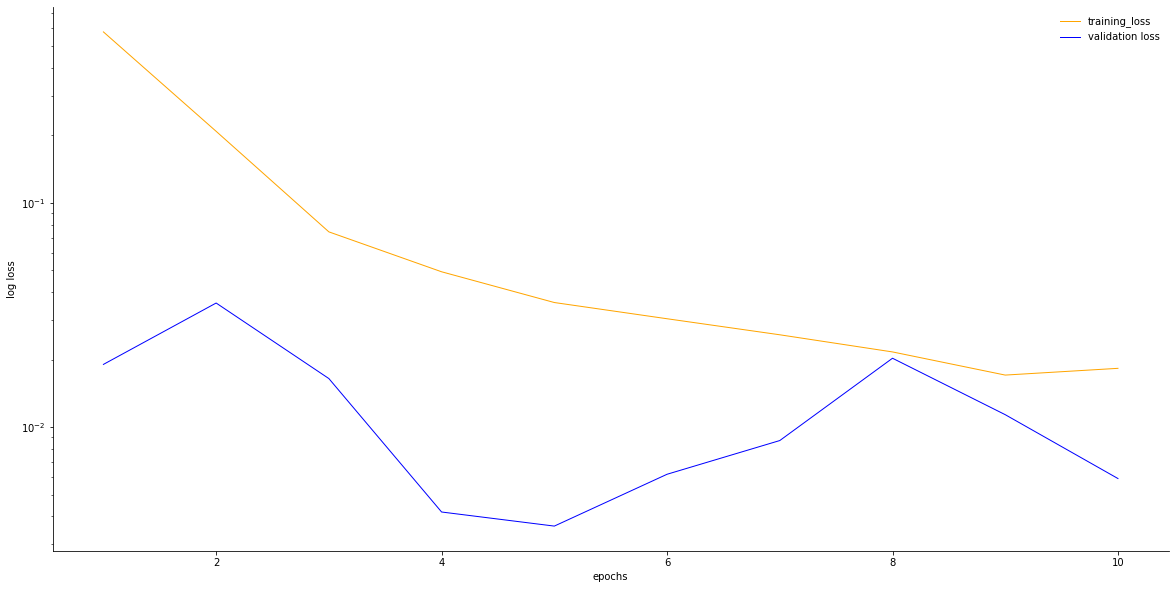

In [ ]:
best_params = grid_search()

In [ ]:
best_params

{'best_batch_size': 10,
 'best_beta_1': 0.9,
 'best_beta_2': 0.999,
 'best_dropout_rate': 0.05,
 'best_epochs': 10,
 'best_epsilon': 1e-08,
 'best_learning_rate': 0.001,
 'best_val_loss_reached': 0.0036160011870957553,
 'training_time': 10.879305124282837}

In [ ]:
# save the best_params dictionary
with open('best_params.p', 'wb') as fp:
    pk.dump(best_params, fp)

In [ ]:
# try:
#   del best_params
# except:
#   a=3

# with open('/content/best_params.p', 'rb') as fp:
#     best_params = pk.load(fp)

# best_params

In [ ]:
param_json = json.dumps(best_params)
f = open("best_params.json","w")
f.write(param_json)
f.close()

In [ ]:
# try:
#   del best_params
# except:
#   a=3

# f = open("best_params.json", "r")
# try:
#     best_params = json.load(f)
# finally:
#     f.close()

# best_params

## predict using overall best model

In [ ]:
del best_params

In [ ]:
# load the json file later with
f = open("best_params.json", "r")
try:
    best_params = json.load(f)
finally:
    f.close()

best_params

{'best_batch_size': 10,
 'best_beta_1': 0.9,
 'best_beta_2': 0.999,
 'best_dropout_rate': 0.05,
 'best_epochs': 10,
 'best_epsilon': 1e-08,
 'best_learning_rate': 0.001,
 'best_val_loss_reached': 0.0036160011870957553,
 'training_time': 10.879305124282837}

In [ ]:
del model_ht2b
# load overall best model
model_ht2b=tf.keras.models.load_model('model.best.h5',custom_objects={'custom_loss_rmse': custom_loss_rmse})

In [ ]:
susax=0
X_test = test_images_t2b
y_pred_ht2 = model_ht2b.predict(test_images_t2b)

taking the imaginary part of the complex FFT mag-field


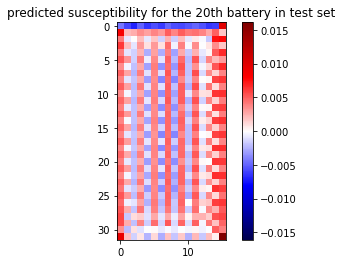

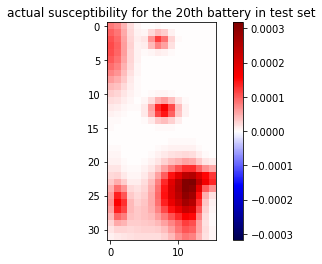

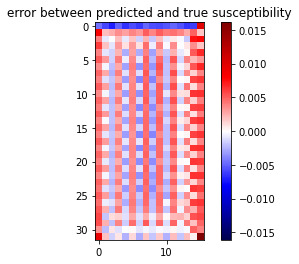

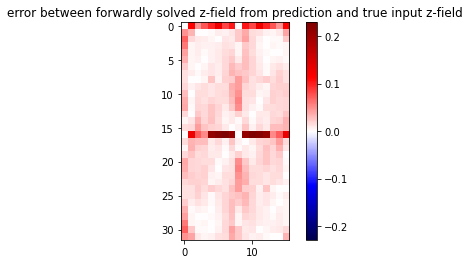

In [ ]:
plt.figure()
imshow_center(y_pred_ht2[20,:,:,susax])
plt.title("predicted susceptibility for the 20th battery in test set")
plt.savefig("test_20_pred.png")

plt.figure()
imshow_center(test_labels_t2b[20,:,:,susax])
plt.title("actual susceptibility for the 20th battery in test set")
plt.savefig("test_20_true.png")

plt.figure()
imshow_center(y_pred_ht2[20,:,:,susax]-test_labels_t2b[20,:,:,susax])
# plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the 20th battery in test set
# we want this difference to be as small as possible, not too extreme in either way
plt.title("error between predicted and true susceptibility")
plt.savefig('test_20_error.png')

zf=calcfield(y_pred_ht2[20,:,:,:])
# calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
# from the predicted susceptibility output
# so we are kind of like recreating the input to see if it is the same as the actual input
# to see if the model learned the dipole forward kernel well

if choice == "abs":
  zf = np.abs(zf)
  print("taking absolute value of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[20,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "real":
  zf = np.real(zf)
  print("taking the real part of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[20,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "imag":
  zf = np.imag(zf)
  print("taking the imaginary part of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[20,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
else:
  print("taking the entire complex number of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[20,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")

# plt.figure()
# imshow_center(np.squeeze(X_test[0,:,:,0])-yf)
# plt.title("error between forwardly solved y-field from prediction and true input y-field")
# plt.savefig('test_20_yfield_diff.png')



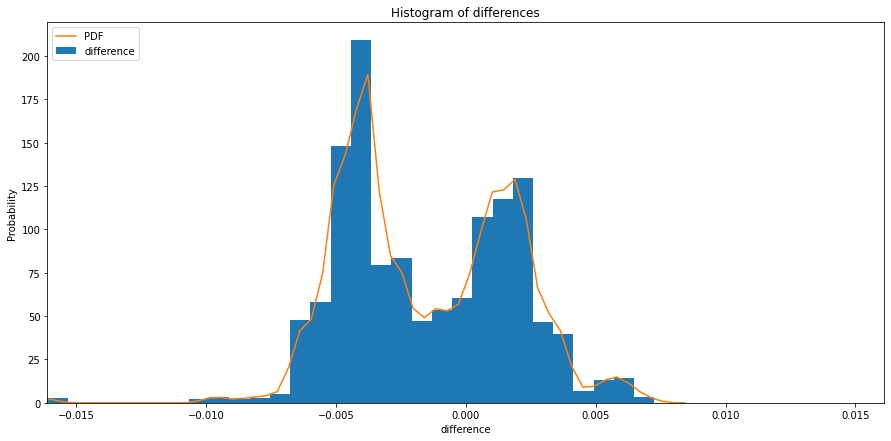

In [ ]:
test_diff = test_labels_t2b - y_pred_ht2
test_diff = tf.keras.backend.flatten(test_diff)
plt.figure(figsize=(15,7))
plt.hist(test_diff, bins=30, density=True, label='difference');
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 60)
kde = stats.gaussian_kde(test_diff)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel('Probability')
plt.xlabel('difference')
range = np.max([np.abs(np.min(test_diff)), np.abs(np.max(test_diff))])
plt.xlim(-range, range)
plt.title("Histogram of differences");
plt.savefig("test_diff_hist.png")

In [ ]:
final_loss = custom_loss_rmse(test_labels_t2b, y_pred_ht2)
print('final RMSE loss on test set:', final_loss.numpy())
NRMSE = final_loss/K.mean(test_labels_t2b)
print('final normalized RMSE loss (div mean) on the test set:', NRMSE.numpy())
RMSE_range = final_loss /(tf.reduce_max(test_labels_t2b) - tf.reduce_min(test_labels_t2b))
print('final normalized RMSE loss (div range) on the test set:', RMSE_range.numpy())
test_arr = tf.keras.backend.flatten(test_labels_t2b).numpy()
IQR = stats.iqr(test_arr)
RMSE_IQR = final_loss/IQR
print('final normalized RMSE loss (div IQR) on the test set:', RMSE_IQR.numpy())
Boll_NRMSE = tf.norm(y_pred_ht2-test_labels_t2b) / tf.norm(test_labels_t2b)
print('final Bollman normalized RMSE loss on the test set:', Boll_NRMSE.numpy())

final RMSE loss on test set: 0.00361609204415609
final normalized RMSE loss (div mean) on the test set: 66.08235327593293
final normalized RMSE loss (div range) on the test set: 7.295056153767324
final normalized RMSE loss (div IQR) on the test set: 46.71217980155363
final Bollman normalized RMSE loss on the test set: 44.28356805334544


In [ ]:
Boll_NRMSE_test_lst = []

for i in np.arange(int(test_labels_t2b.shape[0])):
  # print(i)
  Boll_NRMSE = (tf.norm(y_pred_ht2[i,:,:,:]-test_labels_t2b[i,:,:,:]) 
                / tf.norm(test_labels_t2b[i,:,:,:]))
  Boll_NRMSE_test_lst.append(Boll_NRMSE)

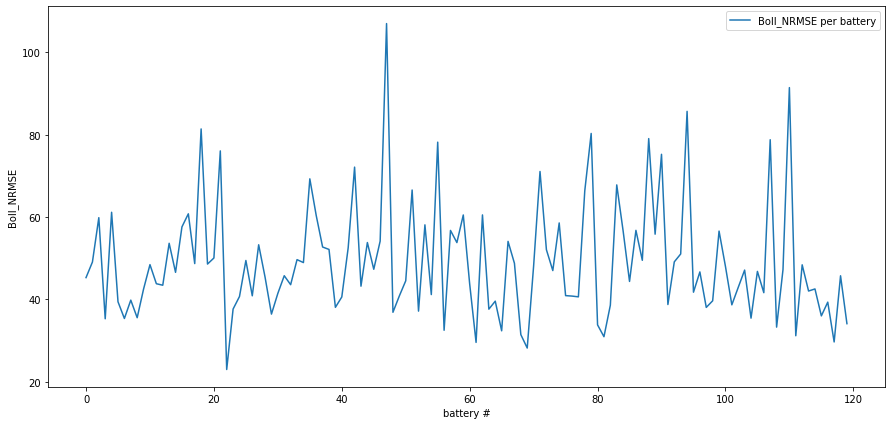

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(Boll_NRMSE_test_lst, label="Boll_NRMSE per battery")
plt.legend()
plt.xlabel("battery #")
plt.ylabel("Boll_NRMSE")
plt.savefig("Boll_NRMSE_per_battery.png")

The best predicted battery is battery 22 from the test set with a Boll_NRMSE of  23.015423174826577
taking the imaginary part of the complex FFT mag-field


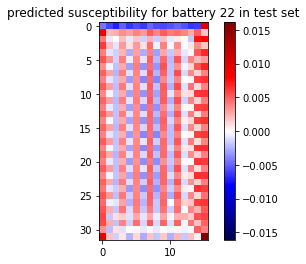

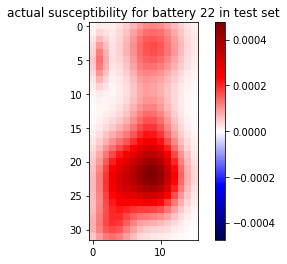

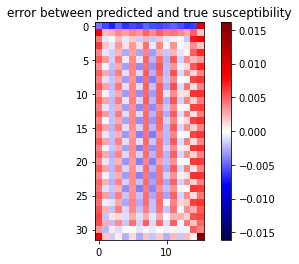

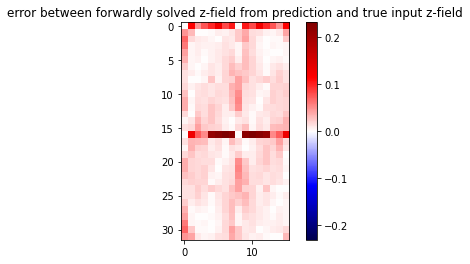

In [ ]:
best_batt = np.argmin(Boll_NRMSE_test_lst)
best_batt_NRMSE = min(Boll_NRMSE_test_lst).numpy()
print("The best predicted battery is battery", best_batt, "from the test set with a Boll_NRMSE of ", best_batt_NRMSE)

best_pred = y_pred_ht2[best_batt,:,:,susax]

plt.figure()
imshow_center(y_pred_ht2[best_batt,:,:,susax])
plt.title("predicted susceptibility for battery "+str(best_batt)+" in test set")
plt.savefig("test_best_pred.png")

plt.figure()
imshow_center(test_labels_t2b[best_batt,:,:,susax])
plt.title("actual susceptibility for battery "+str(best_batt)+" in test set")
plt.savefig("test_best_true.png")

plt.figure()
imshow_center(y_pred_ht2[best_batt,:,:,susax]-test_labels_t2b[best_batt,:,:,susax])
# plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the best battery in test set
# we want this difference to be as small as possible, not too extreme in either way
plt.title("error between predicted and true susceptibility")
plt.savefig('test_best_error.png')

zf=calcfield(y_pred_ht2[best_batt,:,:,:])
# calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
# from the predicted susceptibility output
# so we are kind of like recreating the input to see if it is the same as the actual input
# to see if the model learned the dipole forward kernel well

if choice == "abs":
  zf = np.abs(zf)
  print("taking absolute value of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[best_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "real":
  zf = np.real(zf)
  print("taking the real part of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[best_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "imag":
  zf = np.imag(zf)
  print("taking the imaginary part of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[best_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
else:
  print("taking the entire complex number of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[best_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")

# plt.figure()
# imshow_center(np.squeeze(X_test[best_batt,:,:,0])-yf)
# plt.title("error between forwardly solved y-field from prediction and true input y-field")
# plt.savefig('test_best_yfield_diff.png')

The worst predicted battery is battery 47 from the test set with a Boll_NRMSE of  106.94203131069199
taking the imaginary part of the complex FFT mag-field


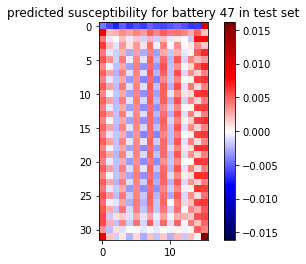

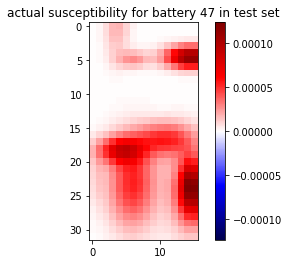

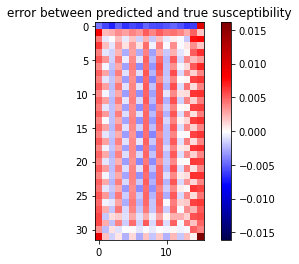

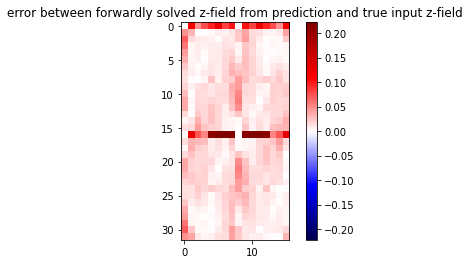

In [ ]:
worst_batt = np.argmax(Boll_NRMSE_test_lst)
worst_batt_NRMSE = max(Boll_NRMSE_test_lst).numpy()
print("The worst predicted battery is battery", worst_batt, "from the test set with a Boll_NRMSE of ", worst_batt_NRMSE)

worst_pred = y_pred_ht2[worst_batt,:,:,susax]

plt.figure()
imshow_center(y_pred_ht2[worst_batt,:,:,susax])
plt.title("predicted susceptibility for battery "+str(worst_batt)+" in test set")
plt.savefig("test_worst_pred.png")

plt.figure()
imshow_center(test_labels_t2b[worst_batt,:,:,susax])
plt.title("actual susceptibility for battery "+str(worst_batt)+" in test set")
plt.savefig("test_worst_true.png")

plt.figure()
imshow_center(y_pred_ht2[worst_batt,:,:,susax]-test_labels_t2b[worst_batt,:,:,susax])
# plot the the predicted susceptibility - actual susceptibility in the same chanel which is '2' for the best battery in test set
# we want this difference to be as small as possible, not too extreme in either way
plt.title("error between predicted and true susceptibility")
plt.savefig('test_worst_error.png')

zf=calcfield(y_pred_ht2[worst_batt,:,:,:])
# calculate the y(dimension 0) and z(dimension 1) component of the magnetic field for the 20th battery
# from the predicted susceptibility output
# so we are kind of like recreating the input to see if it is the same as the actual input
# to see if the model learned the dipole forward kernel well

if choice == "abs":
  zf = np.abs(zf)
  print("taking absolute value of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[worst_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "real":
  zf = np.real(zf)
  print("taking the real part of the complex FFT mag-field")
  plt.figure()
  imshow_center((np.squeeze(X_test[worst_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
elif choice == "imag":
  zf = np.imag(zf)
  print("taking the imaginary part of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[worst_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")
else:
  print("taking the entire complex number of the complex FFT mag-field")
  plt.figure()
  imshow_center(np.abs(np.squeeze(X_test[worst_batt,:,:,0])-zf))
  plt.title("error between forwardly solved z-field from prediction and true input z-field")

# plt.figure()
# imshow_center(np.squeeze(X_test[worst_batt,:,:,0])-yf)
# plt.title("error between forwardly solved y-field from prediction and true input y-field")
# plt.savefig('test_worst_yfield_diff.png')


In [ ]:
print("are predictions for the two different batteries different?" ,
      np.all(y_pred_ht2[worst_batt,:,:,susax] == y_pred_ht2[best_batt,:,:,susax]) == False)

are predictions for the two different batteries different? False


In [ ]:
# note that these changes with each execution!
# because the object created from this slice is temporary and is not stored nor fixed
print(id(y_pred_ht2[worst_batt,:,:,0]))
print(id(y_pred_ht2[best_batt,:,:,0]))

140305131374112
140305131374112


In [ ]:
# only an individual number that is NOT an integer is actually a fixed object and can be used to check
# to see if it is a part of the same object in a sense
print(id(y_pred_ht2[worst_batt][0][0][0]))
print(id(y_pred_ht2[best_batt][0][0][0]))

140306426098912
140306426098912


In [ ]:
print((y_pred_ht2[worst_batt][0][0][0]))
print((y_pred_ht2[best_batt][0][0][0]))

-0.004360717
-0.004360717


In [ ]:
print(id(worst_pred))
print(id(best_pred))

140305189544144
140305143936544


In [ ]:
a = [1,2,3,4]
b = a[0:3]
c = a[0:3]
print(id(b))
print(id(c))
# ids are different even though they point to the same slice!

140305128840520
140305131836680


In [ ]:
a = [1.1, 2, 3, 4]
aa = [4, 3, 2, 1.1]
b = a[2]
c = a[2]

In [ ]:
print(id(b))
print(id(c))
# id's are the same when they point to the same 1 particular INTEGER element!

print(id(a[0]))
print(id(aa[-1]))

print(id(aa[1]))
print(id(3))

10914560
10914560
140305144232672
140306427570096
10914560
10914560
